# Advanced Lane Finding Project
The goals / steps of this project are the following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll compute the camera calibration using chessboard images

In [97]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

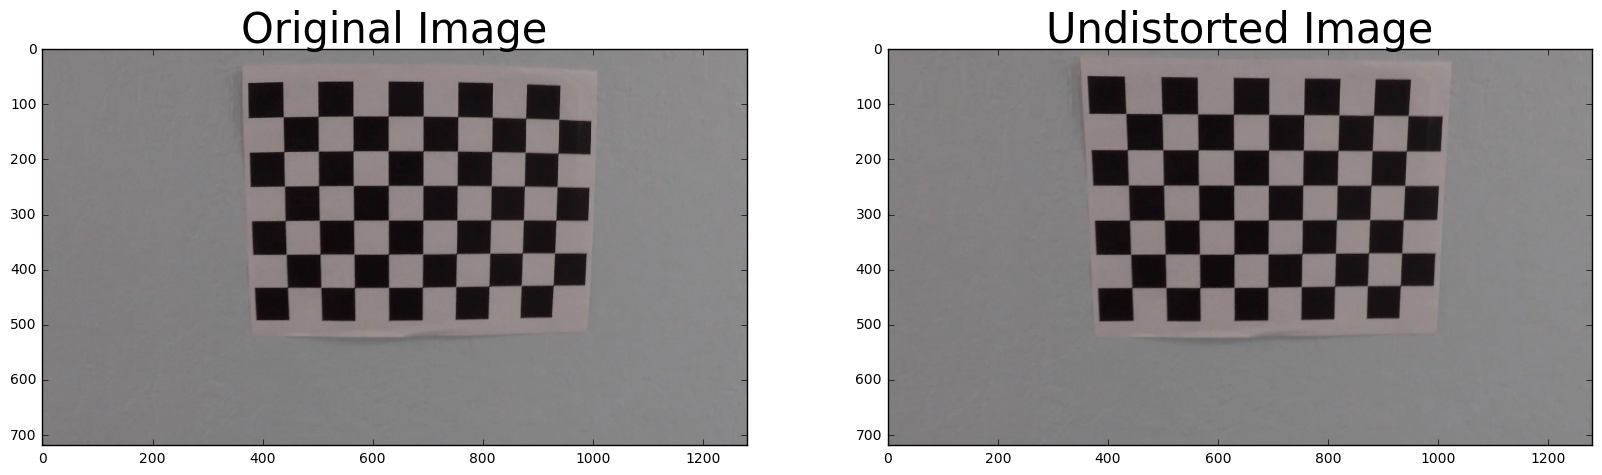

In [98]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration18.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_calibration18.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

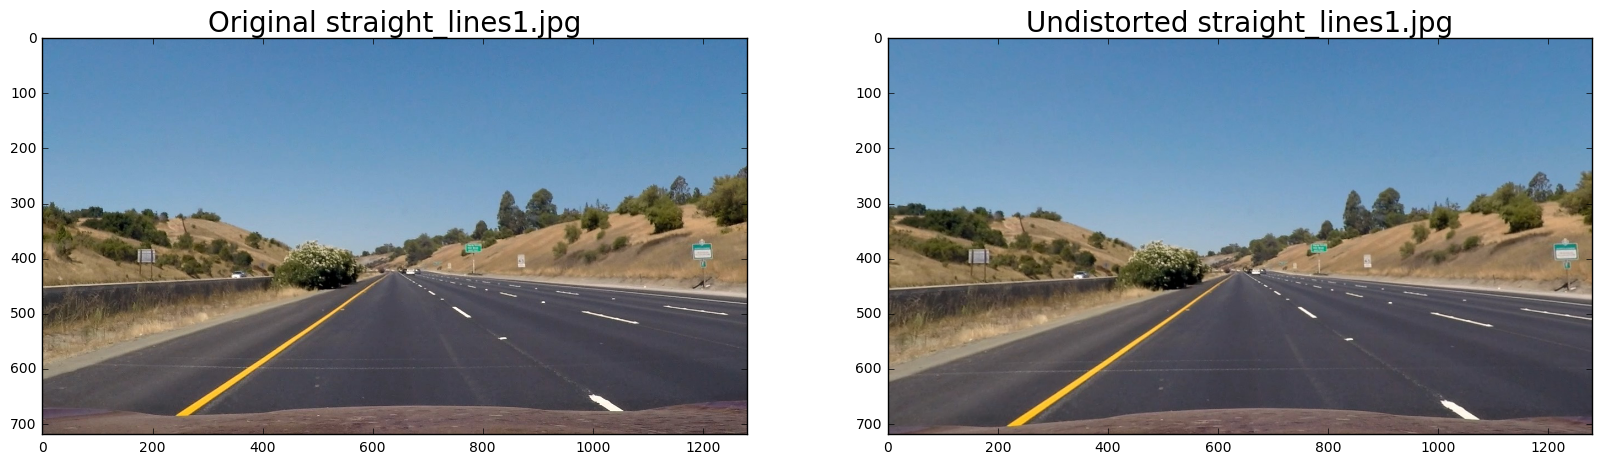

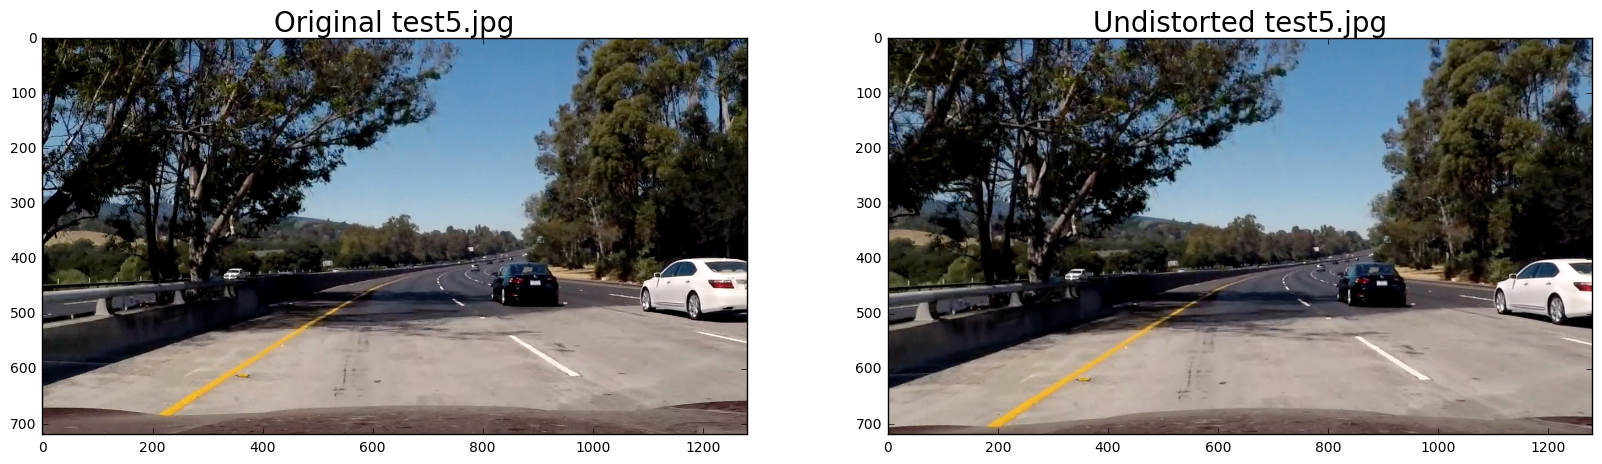

In [126]:
def undistort(input_image):
    distortion = pickle.load(open( "output_images/dist_pickle.p", "rb" ) )
    return cv2.undistort(input_image, distortion["mtx"], distortion["dist"], None, distortion["mtx"])

# Test undistortion on a lane image
img_str8 = cv2.imread('test_images/straight_lines1.jpg')
img_test5 = cv2.imread('test_images/test5.jpg')

img_str8_undistorted = undistort(img_str8)
img_test5_undistorted = undistort(img_test5)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img_str8, cv2.COLOR_BGR2RGB)) # OpenCV imread is BGR, matplotlib is RGB
ax1.set_title('Original straight_lines1.jpg', fontsize=20)
ax2.imshow(cv2.cvtColor(img_str8_undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted straight_lines1.jpg', fontsize=20)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img_test5, cv2.COLOR_BGR2RGB))
ax1.set_title('Original test5.jpg', fontsize=20)
ax2.imshow(cv2.cvtColor(img_test5_undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted test5.jpg', fontsize=20)

In [128]:
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_CUBIC)  # keep same size as input image

    return warped

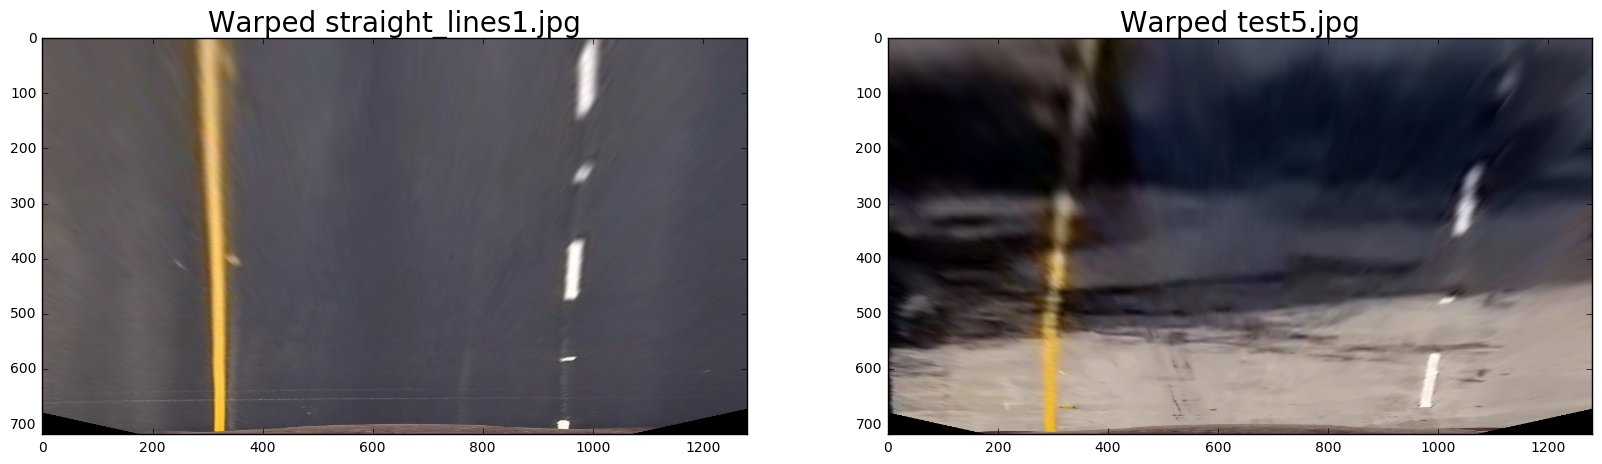

In [129]:
img_str8_warped = warper(img_str8_undistorted)
img_test5_warped = warper(img_test5_undistorted)

# Visualize warping
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
img_str8_warped = cv2.cvtColor(img_str8_warped, cv2.COLOR_BGR2RGB)
ax1.imshow(img_str8_warped)
ax1.set_title('Warped straight_lines1.jpg', fontsize=20)
img_test5_warped = cv2.cvtColor(img_test5_warped, cv2.COLOR_BGR2RGB)
ax2.imshow(img_test5_warped)
ax2.set_title('Warped test5.jpg', fontsize=20)

The results above show us that our perspective warp is working fine.

## The next step is to prepare the image images before edge detection, focusing on yellow and white lines

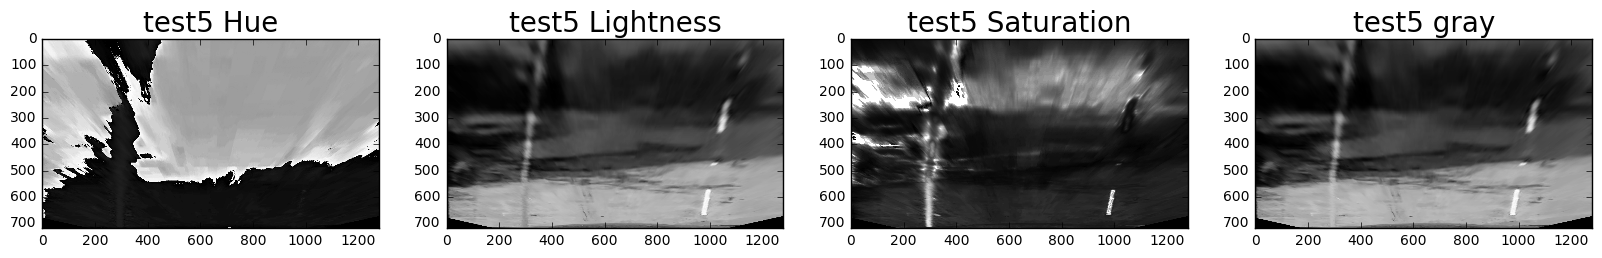

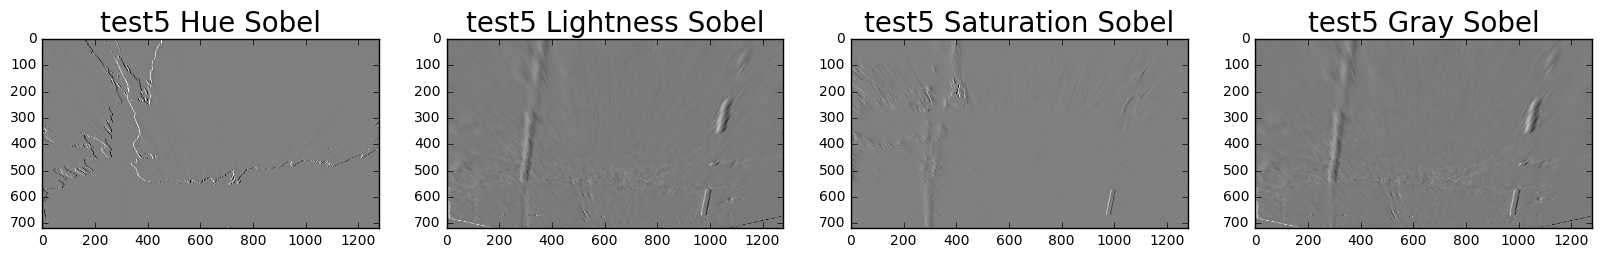

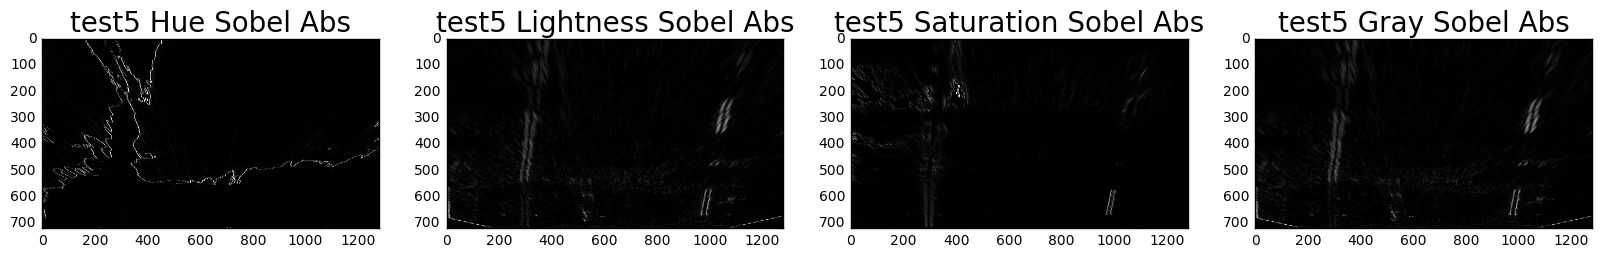

In [102]:
# test a few images first
test5_HLS_img = cv2.cvtColor(img_test5_warped, cv2.COLOR_RGB2HLS).astype(np.float)

# Visualize HSL
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,10))
ax0.imshow(test5_HLS_img[:,:,0], cmap='gray')
ax0.set_title('test5 Hue', fontsize=20)
ax1.imshow(test5_HLS_img[:,:,1], cmap='gray')
ax1.set_title('test5 Lightness', fontsize=20)
ax2.imshow(test5_HLS_img[:,:,2], cmap='gray')
ax2.set_title('test5 Saturation', fontsize=20)
gray = cv2.cvtColor(img_test5_warped, cv2.COLOR_RGB2GRAY)
ax3.imshow(gray, cmap='gray')
ax3.set_title('test5 gray', fontsize=20)

test5_H_sobelx = cv2.Sobel(test5_HLS_img[:,:,0], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_H_sobelx = np.absolute(test5_H_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_H_sobelx = np.uint8(255*abs_test5_H_sobelx/np.max(abs_test5_H_sobelx))
test5_L_sobelx = cv2.Sobel(test5_HLS_img[:,:,1], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_L_sobelx = np.absolute(test5_L_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_L_sobelx = np.uint8(255*abs_test5_L_sobelx/np.max(abs_test5_L_sobelx))
test5_S_sobelx = cv2.Sobel(test5_HLS_img[:,:,2], cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_S_sobelx = np.absolute(test5_S_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_S_sobelx = np.uint8(255*abs_test5_S_sobelx/np.max(abs_test5_S_sobelx))
test5_Gray_sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
abs_test5_Gray_sobelx = np.absolute(test5_Gray_sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_test5_Gray_sobelx = np.uint8(255*abs_test5_Gray_sobelx/np.max(abs_test5_Gray_sobelx))

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize = (20,10))
ax0.imshow(test5_H_sobelx, cmap='gray')
ax0.set_title('test5 Hue Sobel', fontsize = 20)
ax1.imshow(test5_L_sobelx, cmap='gray')
ax1.set_title('test5 Lightness Sobel', fontsize = 20)
ax2.imshow(test5_S_sobelx, cmap='gray')
ax2.set_title('test5 Saturation Sobel', fontsize = 20)
ax3.imshow(test5_Gray_sobelx, cmap='gray')
ax3.set_title('test5 Gray Sobel', fontsize = 20)

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize = (20,10))
ax0.imshow(scaled_test5_H_sobelx, cmap='gray')
ax0.set_title('test5 Hue Sobel Abs', fontsize = 20)
ax1.imshow(scaled_test5_L_sobelx, cmap='gray')
ax1.set_title('test5 Lightness Sobel Abs', fontsize = 20)
ax2.imshow(scaled_test5_S_sobelx, cmap='gray')
ax2.set_title('test5 Saturation Sobel Abs', fontsize = 20)
ax3.imshow(scaled_test5_Gray_sobelx, cmap='gray')
ax3.set_title('test5 Gray Sobel Abs', fontsize = 20)

The results above show that thresholding on the Lightness/Gray and Saturation channels would give us the best benefit.  The Hue channel is not usable in shadow regions.

## Detect lane pixels 

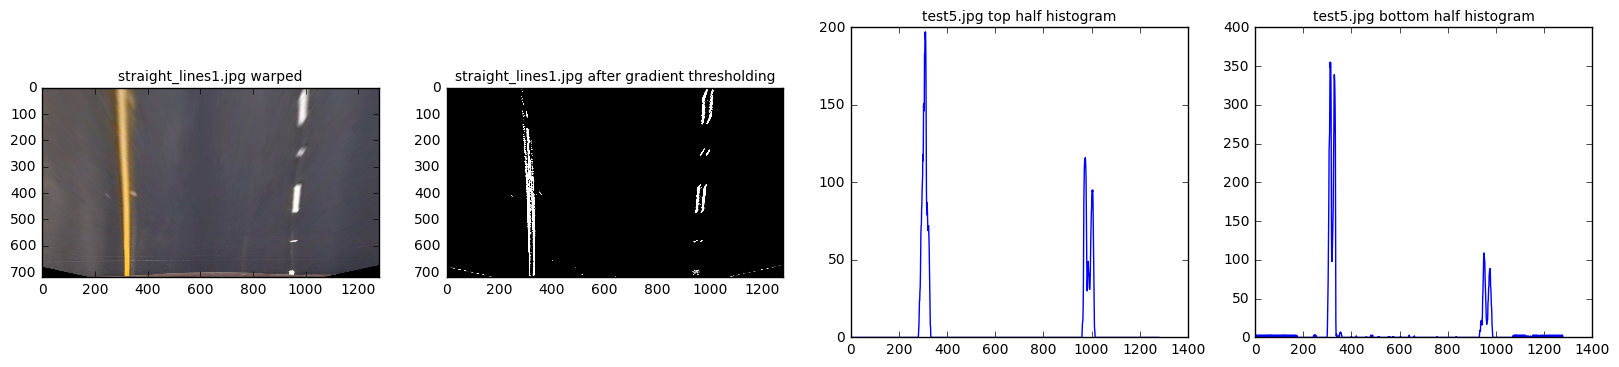

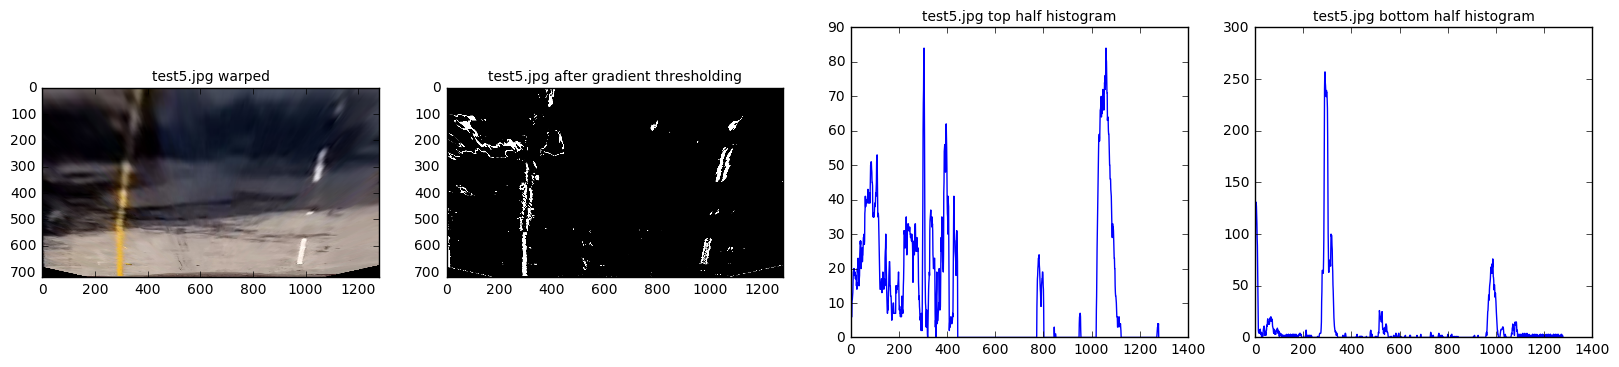

In [103]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(175, 245), sx_thresh=(25, 145)):
    img = np.copy(img)
    # Convert to HLS color space and separate the L, S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # return combination
    s_or_sx = np.zeros_like(sxbinary)
    s_or_sx[(s_binary == 1) | (sxbinary == 1)] = 1
    return s_or_sx
    
img_str8_warped_binary = pipeline(img_str8_warped)

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))

ax1.imshow(img_str8_warped)
ax1.set_title('straight_lines1.jpg warped', fontsize = 10)
ax2.imshow(img_str8_warped_binary, cmap='gray')
ax2.set_title('straight_lines1.jpg after gradient thresholding', fontsize = 10)
ax3.plot(np.sum(img_str8_warped_binary[:int(img_str8_warped_binary.shape[0]/2),:], axis=0))
ax3.set_title('test5.jpg top half histogram', fontsize = 10)
ax4.plot(np.sum(img_str8_warped_binary[int(img_str8_warped_binary.shape[0]/2):,:], axis=0))
ax4.set_title('test5.jpg bottom half histogram', fontsize = 10)
    
img_test5_warped_binary = pipeline(img_test5_warped)

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,4))

ax1.imshow(img_test5_warped)
ax1.set_title('test5.jpg warped', fontsize = 10)
ax2.imshow(img_test5_warped_binary, cmap='gray')
ax2.set_title('test5.jpg after gradient thresholding', fontsize = 10)
ax3.plot(np.sum(img_test5_warped_binary[:int(img_test5_warped_binary.shape[0]/2),:], axis=0))
ax3.set_title('test5.jpg top half histogram', fontsize = 10)
ax4.plot(np.sum(img_test5_warped_binary[int(img_test5_warped_binary.shape[0]/2):,:], axis=0))
ax4.set_title('test5.jpg bottom half histogram', fontsize = 10)

The results of our image processing show us that for some difficult frames, portions of the lane will not be correctly detected unless a smart algorithm is put into place.  For instance, it could start at the bottom of the frame to find, follow and predict the curvature for higher parts of the frame, disregarding any other peaks.  Another way is if the right lane is definately identified, to predict where the left lane should be - since the distance between the lane lines is known.

## Determine Lane Curvature and Vehicle position with respect to center

In [135]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def scan_for_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print('left radius:', left_curverad, 'pixels', '- right radius:', right_curverad, 'pixels')
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('left radius:', left_curverad, 'm', '- right radius:', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_fit, right_fit, out_img

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# plot function
def plot_lanes_on_warped(left_fit, right_fit, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # color left lane red
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # color right lane blue
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

left radius: 5800.95758254 pixels - right radius: 126048.990228 pixels
left radius: 1905.04114016 m - right radius: 41080.1004912 m


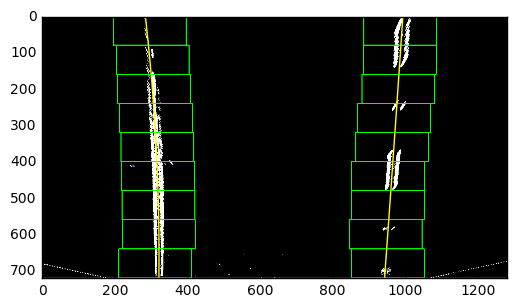

In [106]:
str8_left_fit, str8_right_fit, str8_out_img = scan_for_lanes(img_str8_warped_binary)
plot_lanes_on_warped(str8_left_fit, str8_right_fit, str8_out_img)

The polynomial fitting on clean images works great.

left radius: 1235.01057513 pixels - right radius: 3416.89958321 pixels
left radius: 375.506692441 m - right radius: 1106.22272278 m


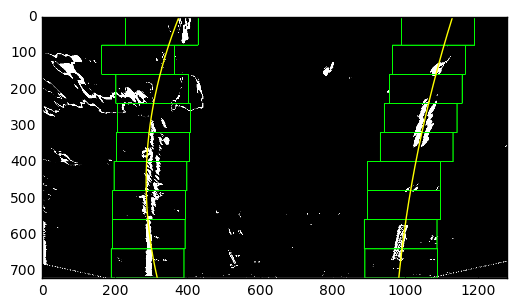

In [107]:
test5_left_fit, test5_right_fit, test5_out_img = scan_for_lanes(img_test5_warped_binary)
plot_lanes_on_warped(test5_left_fit, test5_right_fit, test5_out_img)

On the shadowy image, the left lane isnt calculated accurately and results in an extra bend

In [108]:
def another_funk():
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [109]:
def another_funk_plot():
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

## Draw lines back onto original image

In [130]:
def unwarper(left_fit, right_fit, warped, undist):
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    # Create an image to draw the lines on
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Calculate Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

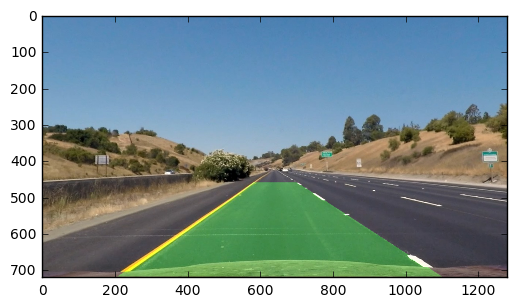

In [131]:
img_str8_undist_plus_lanes = unwarper(str8_left_fit, str8_right_fit, img_str8_warped, img_str8_undistorted)
plt.imshow(cv2.cvtColor(img_str8_undist_plus_lanes, cv2.COLOR_BGR2RGB))

In perfect conditions the unwarped polygon looks to be a perfect fit.

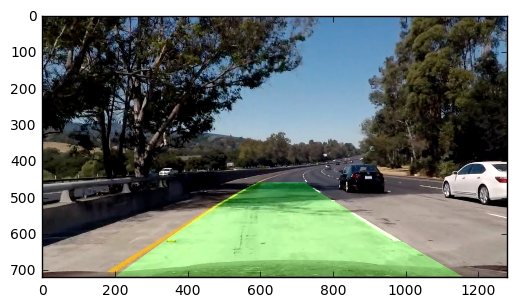

In [132]:
img_test5_undist_plus_lanes = unwarper(test5_left_fit, test5_right_fit, img_test5_warped, img_test5_undistorted)
plt.imshow(cv2.cvtColor(img_test5_undist_plus_lanes, cv2.COLOR_BGR2RGB))

The poor fit on the polyline is seen here, but it is not as dramatic as from the "birds eye" perspective.

## Run it on a movie

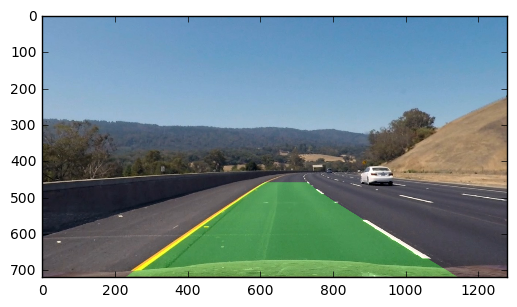

In [136]:
def process(image):
    undistorted_image = undistort(image)
    warped_image = warper(undistorted_image)
    binary_warped_image = pipeline(warped_image)
    left_fit, right_fit, out_img = scan_for_lanes(binary_warped_image)
    output = unwarper(left_fit, right_fit, warped_image, undistorted_image)
    return output

img_test = cv2.imread('test_images/test3.jpg')
plt.imshow(cv2.cvtColor(process(img_test), cv2.COLOR_BGR2RGB))

In [137]:
from moviepy.editor import VideoFileClip

print('Processing video ...')
##clip = VideoFileClip('harder_challenge_video.mp4')
#clip = VideoFileClip('challenge_video.mp4')
input_clip = VideoFileClip('project_video.mp4')
video_clip = input_clip.fl_image(process)
output_file = 'output_images\project_video_processed.mp4'
video_clip.write_videofile(output_file, audio=False)

Processing video ...
[MoviePy] >>>> Building video output_images\project_video_processed.mp4
[MoviePy] Writing video output_images\project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:09<00:00,  9.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images\project_video_processed.mp4 

